# Faire un métamodèle de krigeage (avec normalisation)

## Références

http://openturns.github.io/openturns/master/theory/meta_modeling/kriging.html

http://openturns.github.io/openturns/master/examples/meta_modeling/kriging.html

[Formation ITECH, Introduction aux métamodèles (polynômes de chaos et krigeage) (ARN4889)
14 septembre 2016, Copyright EDF 2015 - Géraud Blatman (EDF R&D/MMC) & Loïc Le Gratiet (EDF R&D/MRI)][1]

[François Bachoc. Introduction to Gaussian-process based Kriging models for metamodeling and validation of computer codes. Seminar of the LRC MANON, INSTN Saclay, March 2014.][2]

[C. E. Rasmussen & C. K. I. Williams, Gaussian Processes for Machine Learning, the MIT Press, 2006,
ISBN 026218253X. 2006 Massachusetts Institute of Technology.][3]

[François Bachoc. Parametric estimation of covariance function in Gaussian-process based Kriging models. Application to uncertainty quantification for computer experiments. Thèse de l'université Paris-Diderot, 2013.][4]

[Loïc Le Gratiet. Multi-fidelity Gaussian process regression for computer experiments. Thèse de l'université Paris-Diderot, 2013.][5]

[1]: https://forge.pleiade.edf.fr/documents/317
[2]: https://www.math.univ-toulouse.fr/~fbachoc/LRC_Manon_2014.pdf
[3]: www.GaussianProcess.org/gpml
[4]: https://tel.archives-ouvertes.fr/tel-00881002/
[5]: https://tel.archives-ouvertes.fr/tel-00866770

## Rappels méthodologiques

### Krigeage

On considère une fonction $G$ :
$$
y = G(\boldsymbol{x})
$$
pour tout $\boldsymbol{x}\in\mathbb{R}^d$. Dans ce document, on considère que la sortie du code de calcul $y\in\mathbb{R}$ est scalaire. 

Le krigeage est une technique permettant de créer un métamodèle de la fonction G. Il est fondé sur les processus gaussiens et c'est pourquoi on nomme parfois cette technique *régression par processus gaussien*.

En d'autres termes, le krigeage consiste à modéliser Z par un processus gaussien de moyenne $m$ et de covariance $k$ :
$$
Z(\boldsymbol{x}) = PG\left(m(\boldsymbol{x}),k(\boldsymbol{x}, \boldsymbol{x}')\right)
$$


### Modèle de tendance

Pour définir la moyenne du processus gaussien, on fait le choix d'une base de fonctions 
$$
\boldsymbol{f} = (f_1,...,f_p)
$$
où $p$ est le nombre de fonctions de base. 
Si les paramètres $\boldsymbol{\beta}\in\mathbb{R}^p$ sont connus, alors la moyenne est choisie sous la forme d'un modèle linéaire généralisé :
$$
\boldsymbol{m}(\boldsymbol{x}) = \boldsymbol{f}(\boldsymbol{x})^T \boldsymbol{\beta}
$$

_Remarque :_ on parle de *krigeage simple* lorsque la moyenne est supposée connue, de *krigeage ordinaire* lorsque la moyenne est inconnue mais supposée constante, sinon de *krigeage universel*. 

### Modèle de covariance

La fonction de covariance contrôle notamment la régularité du processus gaussien (continuité et différentiabilité de ses trajectoires ou en moyenne quadratique).

Pour définir la covariance du processus gaussien, on fait le choix d'une fonction de corrélation $r$ de la forme :
$$
k(\boldsymbol{x}, \boldsymbol{x}') = \sigma^2 r(\boldsymbol{x}, \boldsymbol{x}',\boldsymbol{\theta})
$$
où $\sigma^2$ est la variance du processus gaussien et $\boldsymbol{\theta} \in\mathbb{R}^d$.

### Régression par processus gaussien : principe

Dans la suite, nous considérons le krigeage associé à des observations $\boldsymbol{y}$ non bruitées.

Deux étapes peuvent être distinguées dans le krigeage :
* (1) l'estimation des paramètres $\boldsymbol{\beta}$, $\sigma$ et $\boldsymbol{\theta}$;
* (2) le conditionnement du processus par les données $\boldsymbol{y}$.

#### Étape (1) : estimation des (hyper)paramètres

Une approche rencontrée dans la littérature, appelée *bayesian kriging* ou *full bayesian kriging*, consiste à traiter les variables $\boldsymbol{\beta}$, $\sigma$ ou $\boldsymbol{\theta}$ comme des paramètres incertains que l'on associe à une distribution de probabilité a priori.
Dans OpenTURNS, ces variables sont simplement considérées comme des paramètres à estimer à partir de données censées provenir d'une même réalisation (de la même trajectoire) d'un processus gaussien. Cela est réalisé suivant le principe du maximum de vraisemblance.

La résolution de ce problème d'optimisation (le MV) peut poser des difficultés. Dans ce cas, on peut soit tenter de fournir à OpenTURNS des meilleures valeurs initiales, soit configurer la résolution du problème de manière plus fine en intervenant dans les objets de plus bas niveau.

#### Étape (2) : conditionnement

Nous nous limitons ci-dessous à une présentation du conditionnement (2) lorsque les paramètres $\boldsymbol{\beta}$, $\sigma$ et $\boldsymbol{\theta}$ sont connus (krigeage simple) et que l'on souhaite simplement
une prédiction en une unique point $\boldsymbol{x}\in\mathcal{D}$.

Faisons l'hypothèse que l'on connaît les valeurs de la fonction sur un plan d'expériences $\boldsymbol{x}^{(i)}$ pour $i=1,...,n$ où $n$ est le nombre de simulations. Pour chacune de ces entrées, on suppose que l'on connaît la valeur de la sortie scalaire $y^{(i)}$
pour $i=1,...,n$. On note $\boldsymbol{y} = (y_1,...,y_n)^T$ le vecteur des sorties observées. 

Notons $F$ la matrice de conception associée aux fonctions de base :
$$
F = \left[ f_j\left(\boldsymbol{x}^{(i)}\right),\quad i=1,...,n, \quad j=1,...,p \right].
$$

Notons $R$ la matrice de correlation associée au noyau de corrélation :
$$
R = \left[ r\left(\boldsymbol{x}^{(i)},\boldsymbol{x}^{(j)},\boldsymbol{\theta}\right),\quad i,j=1,...,n \right]
$$

Considérons un nouveau point $\boldsymbol{x} \in \mathbb{R}^{d}$ correspondant à une sortie $y$ inconnue.
Notons $\boldsymbol{r}(\boldsymbol{x})$ le vecteur des corrélation entre le point $\boldsymbol{x}$ et les points du plan d'expériences :
$$
\boldsymbol{r}(\boldsymbol{x}) = \left[r\left(\boldsymbol{x},\boldsymbol{x}^{(i)},\boldsymbol{\theta}\right),\quad i=1,...,n \right]^T
$$

On peut démontrer que le vecteur aléatoire associé aux observations $\boldsymbol{Y}$ et la variable aléatoire $Y(\boldsymbol{x})$ sont liés par une loi normale :

$$
\begin{pmatrix}
\boldsymbol{Y} \\
Y(\boldsymbol{x})
\end{pmatrix}
= 
\mathcal{N}
\left(
\begin{pmatrix}
F \boldsymbol{\beta} \\
\boldsymbol{f(x)}^T \boldsymbol{\beta}
\end{pmatrix}
,
\sigma^2 
\begin{pmatrix}
R & \boldsymbol{r}(\boldsymbol{x}) \\
\boldsymbol{r}(\boldsymbol{x})^T & 1 \\
\end{pmatrix}
\right)
$$

Le modèle prédictif est donné par loi de $Z(\boldsymbol{x})$ conditionnée par les observations connues du code :
$$
\tilde{Y}(\boldsymbol{x}) = \left[ \boldsymbol{Y}(\boldsymbol{x}) 
| \boldsymbol{Y} = \boldsymbol{y}, 
\boldsymbol{\theta} = \boldsymbol{\theta}, 
\boldsymbol{\sigma} = \boldsymbol{\sigma} \right].
$$

On peut démontrer que $\tilde{\boldsymbol{Y}}(\boldsymbol{x})$ est également une variable aléatoire gaussienne :
$$
\tilde{Y}(\boldsymbol{x}) \sim \mathcal{N} \left( \mu_{\tilde{Y}}(\boldsymbol{x}) , \sigma_{\tilde{Y}}(\boldsymbol{x})^2 \right)
$$
où la moyenne $\mu_{\tilde{Y}}(\boldsymbol{x})$ et la variance $\sigma_{\tilde{Y}}(\boldsymbol{x})^2$ s'écrivent de manière explicite (voir la propriété de conditionnement des processus gaussiens dans le précédent *notebook*).

Les calculs liés au conditionnement n'impliquent que la résolution de systèmes d'équations linéaires. 
Néanmoins, si $n$ est grand (par exemple $n=10000$), alors la matrice de corrélation $R$ est de taille $n\times n$, ce qui peut poser des difficultés de performance, voire de mémoire. Pour résoudre ce problème, une alternative consiste à utiliser des techniques de compression de matrices, comme par exemple la technique des H-mat utilisée par OpenTURNS.

#### Remarque

Dans le cas du krigeage universel et d'une fonction de covariance à estimer, la définition de la fonction de covariance conditionnée est en fait modifiée pour tenir compte de l'incertitude sur $\boldsymbol{\beta}$.

## Le krigeage dans OpenTURNS

### Le modèle de déviation de la poutre encastrée

Dans l'exemple qui suit, on considère le modèle de déviation de la poutre encastrée. Dans ce modèle, on considère 4 variables aléatoires liées par une copule Gaussienne. 

<img src="poutre.png" width="300px">

On considère 4 variables aléatoires :
 - E : le module d'Young [Pa]
 - F : la force appliquée [N]
 - L : la longueur [m]
 - I : le moment d'inertie de la poutre [m^4]

La déviation verticale de la poutre sous l'effet de la force appliquée est modélisée par l'équation :
$$
y = \frac{FL^3}{3EI}
$$

On considère les lois de probabilité suivantes :

|Variable|  Distribution|
| ------------- |-------------|
|E| Beta(alpha = 0.9, beta = 2.2, a = $2.5\times 10^7$, $b = 5\times 10^7$) |
|F| Lognormal($\mu_F=3 \times 10^4$, $\sigma_F=9\times 10^3$, shift=$15\times 10^3$)|
|L| Uniform(min=250.0, max= 260.0)|
|I| Beta(alpha = 2.5, beta = 1.5, a = 310, b = 450)|
 
On fait l'hypothèse que les variables aléatoires E, F, L et I sont liées par une copule Gaussienne dont la matrice de corrélation est :
$$
R = 
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & -0.2 \\
0 & 0 & -0.2 & 1
\end{pmatrix}
$$

En d'autres termes, on considère que les variables L et I sont corrélées négativement : lorsque la longueur L augmente, le moment d'inertie I diminue. 

On créé un méta-modèle de krigeage fondé sur un modèle exponentiel carré. Pour estimer le métamodèle, nous allons utiliser un plan d'expériences de taille 20. 

### Définition du modèle

In [51]:
import openturns as ot

model = ot.SymbolicFunction(["E", "F", "L", "I"], ["F*L^3/(3*E*I)"])

# Young's modulus E: beta distribution
E = ot.Beta(0.9, 3.5, 2.5e7, 5.0e7) # in N/m^2
E.setDescription("E")
# Load F: lognormal distribution
F = ot.LogNormal() # in N
F.setParameter(ot.LogNormalMuSigma()([3e4, 9e3, 0.]))
F.setDescription("F")
# Length L: uniform distribution
L = ot.Uniform(2.5, 2.6) # in m
L.setDescription("L")
# Moment of inertia I: beta distribution
I = ot.Beta(2.5, 4, 3.1e2, 4.5e2) # in m^4
I.setDescription("I")

dim = 4 # number of inputs
R = ot.CorrelationMatrix(dim)
R[2, 3] = -0.2 
myCopula = ot.NormalCopula(ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(R))
myDistribution = ot.ComposedDistribution([E, F, L, I], myCopula)

Plan d'expérience (Monte-Carlo simple).

In [52]:
sampleSize_train = 20
X_train = myDistribution.getSample(sampleSize_train)
Y_train = model(X_train)

Maintenant, on veut calculer le méta-modèle. Comme on a vu dans le fichier précédent, l'approche naive ne fonctionne pas. Pour éviter les problèmes d'échelles, on normalise les données à la main avant calcul. On "dénormalisera" pour obtenir le méta-modèle.

In [53]:
# --- 1. Préparation de la fonction de normalisation ---
dimension = myDistribution.getDimension()

# Calcul des statistiques
input_mean = X_train.computeMean()
input_std = X_train.computeStandardDeviation()

# On crée d'abord la fonction de normalisation symbolique
# f(x) = (x - mean) / std
vars = [f"x{i}" for i in range(dimension)]
formulas = [f"(x{i} - {input_mean[i]}) / {input_std[i]}" for i in range(dimension)]
normalize_function = ot.SymbolicFunction(vars, formulas)

# --- 2. Normalisation des données d'entrainement ---
# On applique simplement la fonction à l'échantillon. C'est plus sûr que les opérations manuelles.
X_train_norm = normalize_function(X_train)




Maintenant, on procède au Kriegeage, sur les données normalisées.

In [54]:
# --- 3. Krigeage sur données normalisées ---
# Plus besoin de calculer input_scale, l'échelle est 1.0 par construction !
dimension = X_train.getDimension()
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.SquaredExponential([1.0]*dimension, [1.0]) 

algo = ot.KrigingAlgorithm(X_train_norm, Y_train, covarianceModel, basis)
# Pas besoin de changer d'optimiseur, TNC (le défaut) marchera très bien ici
algo.run()
result = algo.getResult()
meta_model_norm = result.getMetaModel()

On revient au méta-modèle final, sans oublier de dénormaliser (pour revenir aux variances de départ).

In [55]:
# --- 4. Création du méta-modèle final (avec dé-normalisation) ---
# On doit "emballer" le modèle pour qu'il accepte les vraies valeurs physiques
# Fonction : X_physique -> X_norm -> Krigeage -> Y
normalize_function = ot.SymbolicFunction(
    ["x0", "x1", "x2", "x3"],
    [f"(x{i} - {input_mean[i]}) / {input_std[i]}" for i in range(dimension)]
)
krigeageMM = ot.ComposedFunction(meta_model_norm, normalize_function)

print("Kriging normalisé construit avec succès.")

Kriging normalisé construit avec succès.


Maintenant, on peut tester la qualité de notre méta-modèle.

In [56]:
sampleSize_test = 100
X_test = myDistribution.getSample(sampleSize_test)
Y_test = model(X_test)

In [57]:
Y_test_MM = krigeageMM(X_test)

In [58]:
val = ot.MetaModelValidation(Y_test, Y_test_MM)

In [59]:
val.computeR2Score()

class=Point name=Unnamed dimension=1 values=[0.994964]

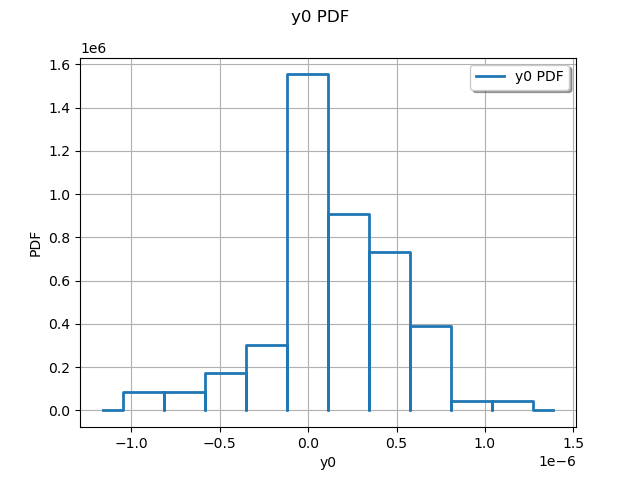

In [60]:
r = val.getResidualSample()
ot.HistogramFactory().build(r).drawPDF()

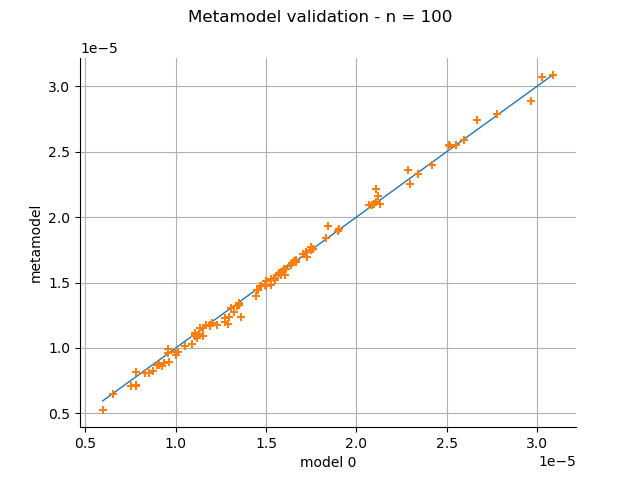

In [61]:
val.drawValidation()

## Exercices

### Exercice 1 : sensibilité à la taille de l'échantillon d'apprentissage

On s'interroge sur l'évolution de la qualité du métamodèle lorsque le nombre de points dans le plan d'expériences augmente. 

**Questions**
* Modifier le plan d'expériences utilisé pour apprendre le méta-modèle : utiliser `sampleSize_train = 100`. 
* Mettre à jour le métamodèle de krigeage. 
* Comment évolue le coefficient de prédictivité ?
* Pourquoi ?

### Exercice 2 : utilisation d'une tendance

Il y a trois classes qui permettent de créer des modèles de tendance.
* `ConstantBasisFactory` : tendance constante
* `LinearBasisFactory` : tendance linéaire
* `QuadraticBasisFactory` : tendance quadratique

**Questions**
* Mettre à jour la tendance du modèle et utiliser une tendance linéaire. 
* Quelle est la tendance estimée par la méthode du maximum de vraisemblance ?
* Quel est l'impact sur la qualité du méta-modèle ?

### Exercice 3 : nombre d'observations et nombre de paramètres

On souhaite vérifier que le nombre d'observations est suffisant pour estimer correctement les paramètres. 

* Calculer le nombre de paramètres estimés dans le krigeage. Pour cela, faire la somme du nombre de paramètres de la tendance et du noyau de covariance.
* Calculer le nombre d'observations dans le plan d'expériences. 
* Calculer le ratio entre le nombre d'observations et le nombre de paramètres. 
* La taille du plan d'expériences est-elle suffisante pour estimer les paramètres ?

### Exercice 4 : distribution des résidus

On souhaite valider la qualité du métamodèle. Nous avons vu comment récupérer les résidus avec la classe `getResidualSample` et tracer l'histogramme de ces résidus avec la classe `HistogramFactory`. Il s'avère que l'on peut récupérer directement la distribution des résidus avec 

**Questions**
* Utiliser la méthode `getResidualDistribution` pour obtenir la distribution des résidus.
* Utiliser la méthode `drawPDF` pour dessiner la distribution des résidus.
* Que conclure ?

### Exercice 1

In [120]:
sampleSize_train = 20
X_train = myDistribution.getSample(sampleSize_train)
Y_train = model(X_train)


In [121]:
# --- 1. Préparation de la fonction de normalisation ---
dimension = myDistribution.getDimension()

# Calcul des statistiques
input_mean = X_train.computeMean()
input_std = X_train.computeStandardDeviation()

# On crée d'abord la fonction de normalisation symbolique
# f(x) = (x - mean) / std
vars = [f"x{i}" for i in range(dimension)]
formulas = [f"(x{i} - {input_mean[i]}) / {input_std[i]}" for i in range(dimension)]
normalize_function = ot.SymbolicFunction(vars, formulas)

# --- 2. Normalisation des données d'entrainement ---
# On applique simplement la fonction à l'échantillon. C'est plus sûr que les opérations manuelles.
X_train_norm = normalize_function(X_train)

In [122]:
# --- 3. Krigeage sur données normalisées ---
# Plus besoin de calculer input_scale, l'échelle est 1.0 par construction !
dimension = X_train.getDimension()
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.SquaredExponential([1.0]*dimension, [1.0]) 

algo = ot.KrigingAlgorithm(X_train_norm, Y_train, covarianceModel, basis)
# Pas besoin de changer d'optimiseur, TNC (le défaut) marchera très bien ici
algo.run()
result = algo.getResult()
print(result.getTrendCoefficients())
meta_model_norm = result.getMetaModel()

[2.18994e-05]


In [123]:
# --- 4. Création du méta-modèle final (avec dé-normalisation) ---
# On doit "emballer" le modèle pour qu'il accepte les vraies valeurs physiques
# Fonction : X_physique -> X_norm -> Krigeage -> Y
normalize_function = ot.SymbolicFunction(
    ["x0", "x1", "x2", "x3"],
    [f"(x{i} - {input_mean[i]}) / {input_std[i]}" for i in range(dimension)]
)
krigeageMM = ot.ComposedFunction(meta_model_norm, normalize_function)

print("Kriging normalisé construit avec succès.")

Kriging normalisé construit avec succès.


In [124]:
sampleSize_test = 100
X_test = myDistribution.getSample(sampleSize_test)
Y_test = model(X_test)
Y_test_MM = krigeageMM(X_test)
val = ot.MetaModelValidation(Y_test, Y_test_MM)
val.computeR2Score()

class=Point name=Unnamed dimension=1 values=[0.991013]

### Exercice 2

In [125]:
# --- 3. Krigeage sur données normalisées ---
# Plus besoin de calculer input_scale, l'échelle est 1.0 par construction !
dimension = X_train.getDimension()
basis = ot.LinearBasisFactory(dimension).build()
covarianceModel = ot.SquaredExponential([1.0]*dimension, [1.0]) 

algo = ot.KrigingAlgorithm(X_train_norm, Y_train, covarianceModel, basis)
# Pas besoin de changer d'optimiseur, TNC (le défaut) marchera très bien ici
algo.run()
result = algo.getResult()
print(result.getTrendCoefficients())

meta_model_norm = result.getMetaModel()

# --- 4. Création du méta-modèle final (avec dé-normalisation) ---
# On doit "emballer" le modèle pour qu'il accepte les vraies valeurs physiques
# Fonction : X_physique -> X_norm -> Krigeage -> Y
normalize_function = ot.SymbolicFunction(
    ["x0", "x1", "x2", "x3"],
    [f"(x{i} - {input_mean[i]}) / {input_std[i]}" for i in range(dimension)]
)
krigeageMM = ot.ComposedFunction(meta_model_norm, normalize_function)

print("Kriging normalisé construit avec succès.")

sampleSize_test = 100
X_test = myDistribution.getSample(sampleSize_test)
Y_test = model(X_test)
Y_test_MM = krigeageMM(X_test)
val = ot.MetaModelValidation(Y_test, Y_test_MM)
val.computeR2Score()

[1.82638e-05,-2.31e-06,5.87916e-06,5.34095e-07,-1.64528e-06]
Kriging normalisé construit avec succès.


class=Point name=Unnamed dimension=1 values=[0.995926]

### Exercice 3

In [126]:
nb_trend_params = result.getTrendCoefficients().getSize()   
print("Number of trend parameters: ", nb_trend_params)
nb_param_cov_kernel = covarianceModel.getParameter().getSize()
print("Number of covariance kernel parameters: ", nb_param_cov_kernel)
res= nb_trend_params + nb_param_cov_kernel
print("Total number of parameters to estimate: ", res)

Number of trend parameters:  5
Number of covariance kernel parameters:  5
Total number of parameters to estimate:  10


In [127]:
nb_observations = X_train.getSize()
print("Number of observations: ", nb_observations)
ratio = nb_observations / res
print("Observation to parameter ratio: ", ratio)

Number of observations:  20
Observation to parameter ratio:  2.0


### Exercice 4

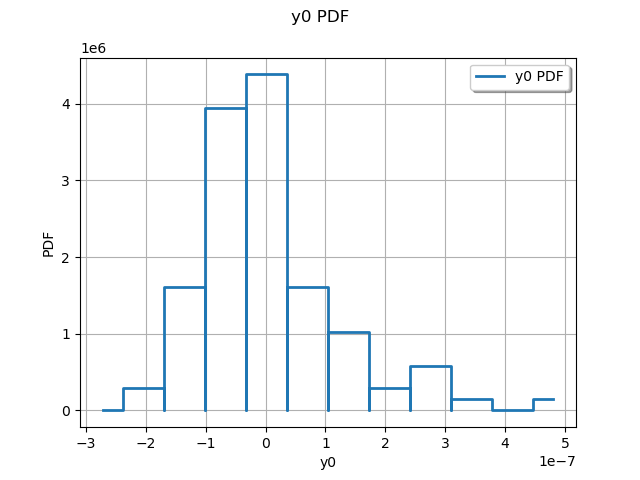

In [128]:
r = val.getResidualSample()
ot.HistogramFactory().build(r).drawPDF()

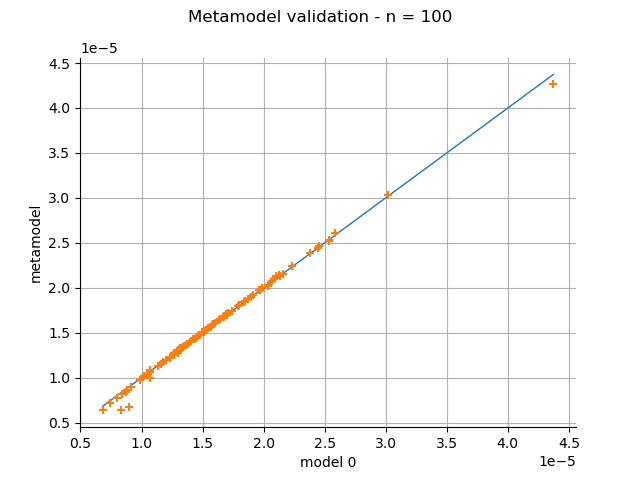

In [129]:
val.drawValidation()